In [28]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
from astropy.io import ascii
#from astropy.table import vstack
#from astropy.modeling import models
import corner
import pickle
import os
from timeit import default_timer as timer
import matplotlib.colors as colors
import matplotlib.cm as cmx
from scipy.optimize import least_squares, curve_fit

In [30]:
def load_data(filename='radio_lightcurve.dat'):
    data = ascii.read(filename)
    
    return data

data = load_data()

# Make a plot of the radio lightcurve
Make a log-log plot of the flux density as a function of time. Make sure to modularise your code so that we can re-use parts of it later on. For bonus points use different markers for each telescope, and use a colour scale to denote the observation frequency.

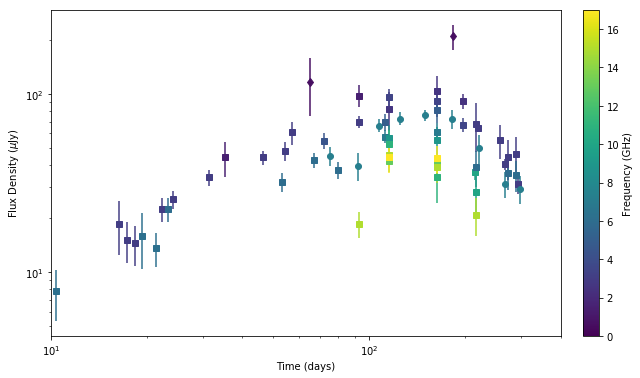

In [51]:
def plot_data(ax, sm, data, scaled=False, **kwargs):
    telescope_marker_dict = {'VLA':'s', 'ATCA':'o', 'GMRT':'d'}
    
    
    for row in data:
        freq = row['frequency']
        colorval = sm.to_rgba(freq)
        
        telescope = row['telescope']
        marker = telescope_marker_dict[telescope]
        
        if scaled:
            flux = row['scaled_flux']
            rms = row['scaled_rms']
        else:
            flux = row['flux']
            rms = row['rms']
        
        ax.errorbar(row['delta_t'], flux, rms, linestyle='', marker=marker, c=colorval, **kwargs)
    return

def cmap_setup(cmap='viridis', min_freq=0, max_freq=17):
    freq_cmap = plt.cm.get_cmap(cmap)
    min_freq = 0
    max_freq = 17
    
    cNorm  = colors.Normalize(vmin=min_freq, vmax=max_freq)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
    sm = scalarMap
    sm._A = []
    
    return sm
    

def make_plot(data, scaled=False):
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    
    sm = cmap_setup()
    plot_data(ax, sm, data, scaled=scaled)
    
    cbar = fig.colorbar(sm,fraction=0.046, pad=0.04)
    cbar.set_label('Frequency (GHz)')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel('Time (days)')
    if scaled:
        ax.set_ylabel('Scaled Flux Density ($\mu$Jy)')
    else:
        ax.set_ylabel('Flux Density ($\mu$Jy)')
    
    ax.set_xlim(10,400)
    
make_plot(data)

# Determining the spectral index
Write a function to take a subset of the data and calculate the spectral index and its uncertainty. Using multi-band observation at 162 days post-merger calculate the spectral index.

In [35]:
def alpha_calc(data):
    freqs = data['frequency']
    flux = data['flux']
    errs = data['rms']
    
    popt, pcov = curve_fit(calc_power_law, freqs, flux ,sigma=flux_errs, p0=(50,-0.61),absolute_sigma=True)
    
    alpha = popt[1]
    alpha_err = np.sqrt(np.diag(pcov))[1]
    
    return alpha, alpha_err

## Scaling the data based on the spectral Index
Write a function to take the observed data and scale it to a specific frequency based on an estimated spectral index. Don't forget to include uncertainties! You should add two columns to your data table called "scaled_flux" and "scaled_rms"

In [42]:
def scale_data(data, alpha, alpha_err, ref_freq=3.0):
    f_scale = (ref_freq/data['frequency'])**alpha
    rms_scale = np.abs(f_scale*np.log(ref_freq/data['frequency'])*alpha_err)
    
    scaled_flux = data['flux'] * f_scale
    scaled_rms = np.abs(scaled_flux) * np.sqrt((data['rms']/data['flux'])**2 + (rms_scale/f_scale)**2)
    
    data['scaled_flux'] = scaled_flux
    data['scaled_rms'] = scaled_rms
    
    return data

Modify your plot_data() and make_plot() functions to add a keyword parameter "scaled" that is by default False. If scaled=True, plot_data() should plot the scaled data instead of the observed data.

Scale the data to 3 GHz based on your estimated spectral index and associated uncertainty, then plot the scaled lightcurve

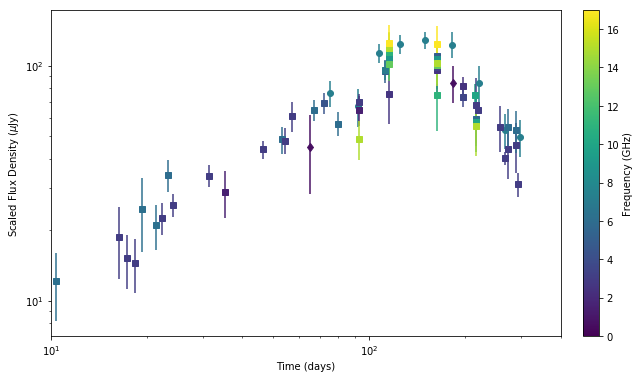

In [53]:
data = scale_data(data, -0.6,0.05)
make_plot(data, scaled=True)

# Fitting the data
We now want to characterise the radio lightcurve. You should be able to see that it initially rises according to a power law, peaks somewhere between 100 and 200 days post-merger and then declines according to a different power law.

However, when we published the first paper demonstrating evidence of a turnover we only had observations up to 200 days post-merger. We will now determine evidence for a turnover using that subset of data.

First, plot the data up to 200 days post-merger by creating a new table called tdata with the data up to 200 days post-merger and at a frequency less than 9 GHz and using your make_plot() function

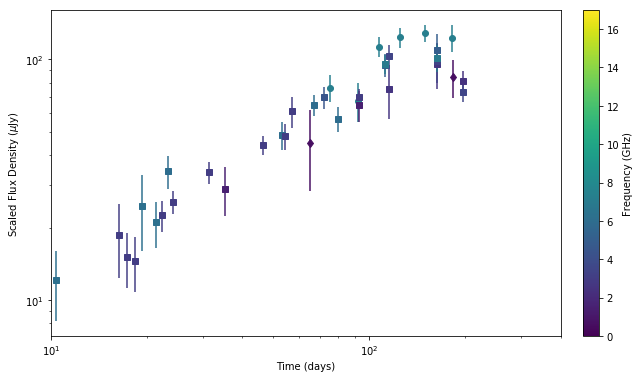

In [57]:
tdata = data[data['delta_t'] < 200]
tdata = tdata[tdata['frequency'] < 9]

make_plot(tdata, scaled=True)

We can fit this data with a "smoothed broken power law", which combines two power laws with a smoothing parameter around the break point. One functional form of this is given by

$S(t) = F_{\rm peak} \left[ \left(\dfrac{t}{t_{\rm peak}}\right)^{-s\delta_1} + \left(\dfrac{t}{t_{\rm peak}}\right)^{-s\delta_2}\right]^{-1/s}$

Right a function smooth_broken_power_law() that outputs a smoothed broken power law that also scales based on frequency and spectral index

In [58]:
def smooth_broken_power_law(t, nu, F_peak, t_peak, delta_1, delta_2, alpha, log_s, nu0=3.0):
    s = 10**log_s

    return (nu/nu0)**alpha * F_peak * ((t/t_peak)**(-s*delta_1) + (t/t_peak)**(-s*delta_2))**(-1.0/s)

## Determining evidence for a turnover

We now want to fit a smoothed broken power law to our data and see if there is evidence for a turnover in the radio lightcurve. In our paper we do this via a parameter grid-search to minimise $\chi$-squared. 

Here we will perform an MCMC fit using the emcee package, to determine lightcurve parameters and the spectral index of the source. First you will need to write 3 functions that define your Probability, Prior and Likelihood.

We will use a uniform prior with $\delta_1>0$ (since we require the lightcurve to initially rise), $0<t_{\rm peak}<300$ (since our data only covers the period up to 200 days) and $s<100$. The parameters will be passed to the function via a tuple.

In [60]:
def lnprior(theta):
    F_peak, t_peak, delta_1, delta_2, alpha, log_s = theta

    if 0.0 < t_peak < 300.0 and delta_1 > 0.0 and log_s < 2:
        return 0.0
    
    else:
        return -np.inf

We will now write a likelihood function that takes the lightcurve parameters inside the tuple theta, along with the observed data.

In [61]:
def lnlike(theta, t, nu, telescope, S, S_err):
    F_peak, t_peak, delta_1, delta_2, alpha, log_s = theta

    model = smooth_broken_power_law(t, nu, F_peak, t_peak, delta_1, delta_2, alpha, log_s)
    inv_sigma2 = 1.0/S_err**2

    return -0.5*(np.sum((S-model)**2*inv_sigma2 - np.log(inv_sigma2)))

Now write a function to calculate the marginal probability using the lnlike() and lnprior() functions you calculated above

In [ ]:
def lnprob(theta,t,nu,telescope,S,S_err):
    lp = lnprior(theta)

    if not np.isfinite(lp):
        return -np.inf

    return lp + lnlike(theta,t,nu,telescope,S,S_err)